# Video Prediction

## 1)Upload the model pre-trained

In [ ]:
import joblib

clf = joblib.load("/Users/lorenzodimaio/Download/SIDS_revelation_project/video_prediction/random_forest_model.pkl")

## 2) Upload the Builder

In [ ]:
from improvement1 import embeddings

builder = embeddings.EmbeddingBuilder("models/4.weights/best.pt", "datasets/onback_onstomach_v2")

## 3) Video prediction function (V1)
Processes a video by applying object detection (YOLO) and keypoint-based classification.

This function reads a video file, performs object detection to extract facial keypoints,
generates features, and applies a trained classifier to predict the baby's position
(e.g., "On Back" or "On Stomach") frame by frame. Bounding boxes and prediction labels
are overlaid on the video, which is saved to disk and optionally displayed.

Parameters:
- input_video_path (str): Path to the input video file.
- builder: An instance of the EmbeddingBuilder for keypoint extraction and feature generation.
- clf: A trained classification model for predicting the baby’s position.
- show_confidences (bool): If True, displays confidence scores on bounding boxes.
- show_all_boxes (bool): If True, draws all detected bounding boxes; if False, only shows the "head".
- default_fps (int): Fallback FPS value if the original video FPS is unavailable.


In [ ]:
import cv2
import os
import numpy as np

valid_boxes_per_frame_without_filter = []

def process_video_without_filters(input_video_path: str, builder, clf, show_confidences: bool = True, show_all_boxes: bool = True, default_fps: int = 20):
    cap = cv2.VideoCapture(input_video_path)

    if not cap.isOpened():
        print("Error in video opening")
    else:
        print("Video uploaded correctly")

    base, ext = os.path.splitext(input_video_path)
    output_video_path = base + "_pred_without_filters.mp4"

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    if fps > default_fps:
        fps = default_fps

    print(f"FPS processing: {fps}")

    out = cv2.VideoWriter(
        output_video_path,
        cv2.VideoWriter_fourcc(*'mp4v'),
        fps,
        (frame_width, frame_height)
    )

    keypoint_colors = {
        "eye": (255, 165, 0),       # orange
        "nose": (127, 255, 212),    # verde acqua
        "mouth": (255, 0, 255),     # fucsia
        "head": (0, 0, 255)         # red
    }

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Prediction with YOLO
        results = builder.model_fd(frame, conf=0.3, verbose=False)[0]
        kpt = builder.keypoints_extractor(results.boxes)

        required_kpts = {"eye", "head", "nose", "mouth"}
        count_valid_boxes = sum(1 for k in required_kpts if k in kpt)
        valid_boxes_per_frame_without_filter.append(count_valid_boxes)

        # Draw bounding box (optional)
        for box, cls_id, conf in zip(results.boxes.xyxy, results.boxes.cls, results.boxes.conf):
            label = builder.classes_fd[int(cls_id.item())].lower()
            if not show_all_boxes and label != "head":
                continue

            color = keypoint_colors.get(label, (255, 255, 255))  # fallback bianco
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

            if show_confidences:
                label_text = f"{label} {conf.item() * 100:.1f}%"
            else:
                label_text = label

            cv2.putText(
                frame,
                label_text,
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.4,
                color,
                1
            )

        # Feature extraction
        builder.keypoints = [kpt]
        builder.y = [0]
        builder.dim_dataset = 1
        image_paths, X, feature = builder.embedding_all_features_norm()

        pred = clf.predict([X[0]])[0]

        if hasattr(clf, "predict_proba"):
            class_index = np.where(clf.classes_ == pred)[0][0]
            prob = clf.predict_proba([X[0]])[0][class_index]
            label_text = f"{'On Back' if pred == 1 else 'On Stomach'} ({prob * 100:.1f}%)"
        else:
            label_text = "On Back" if pred == 1 else "On Stomach"

        # Final Visualization
        if "On Stomach" in label_text:
            color = (0, 0, 255)  # red
        else:
            color = (0, 255, 0)  # green

        cv2.putText(frame, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        cv2.imshow("Video Prediction", frame)
        out.write(frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()

## 3) Video prediction function (V2)
The function applies dynamic contrast and brightness filters based on the quality of keypoint detection:
- Filter Levels (0-3):
Level 0 means no filter; levels 1 to 3 apply increasing adjustments to contrast (alpha) and brightness (beta) using cv2.convertScaleAbs.
- Adaptive Filtering:
The filter level adjusts dynamically depending on recent keypoint detection success over the last 25 frames:
	- If detection success rate is high (>50%), filters are disabled (level 0).
	- If success rate is low (<30%), filter intensity increases progressively to improve visibility.
- Purpose:
These filters enhance image quality in challenging conditions (e.g., low light), helping the model better detect keypoints and improve prediction accuracy.

In [ ]:
#CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(frame):
    lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)

    merged = cv2.merge((l_clahe, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

In [ ]:
def enhance_contrast_brightness(frame,level):

    frame = apply_clahe(frame)

    if level == 1:
        alpha, beta = 1.1, 10   # Poco contrasto, poca luce
    elif level == 2:
        alpha, beta = 1.5, 30   # Medio contrasto/luminosità
    elif level == 3:
        alpha, beta = 5.0, 50   # Più aggressivo
    else:
        raise ValueError("level must be 1, 2, or 3")

    return cv2.convertScaleAbs(frame, alpha=alpha, beta=beta)

In [ ]:
import cv2
import os
import numpy as np
from collections import deque

good_boxes_history = deque(maxlen=25)
valid_boxes_per_frame_with_filter = []

def process_video_with_filters(input_video_path: str, builder, clf, show_confidences: bool = True, show_all_boxes: bool = True, default_fps: int = 20):
    cap = cv2.VideoCapture(input_video_path)

    if not cap.isOpened():
        print("Error in video opening")
    else:
        print("Video uploaded correctly")

    base, ext = os.path.splitext(input_video_path)
    output_video_path = base + "_pred_with_filters.mp4"

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    if fps > default_fps:
        fps = default_fps

    print(f"FPS processing: {fps}")

    out = cv2.VideoWriter(
        output_video_path,
        cv2.VideoWriter_fourcc(*'mp4v'),
        fps,
        (frame_width, frame_height)
    )

    keypoint_colors = {
        "eye": (255, 165, 0),       # orange
        "nose": (127, 255, 212),    # verde acqua
        "mouth": (255, 0, 255),     # fucsia
        "head": (0, 0, 255)         # red
    }

    apply_filters_for_n_frames = 0

    level = 0  # 0 = no filter, 1/2/3 = filtro
    required_kpts = {"eye", "head", "nose", "mouth"}

    stable_success_counter = 0
    min_stable_success_frames = 100  # ← tollerance, to be more conservative and stable

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Apply filter only if level > 0
        if level > 0:
            frame = enhance_contrast_brightness(frame, level)
            print(f"🔧 Applying filter level {level}")

        # Prediction YOLO
        results = builder.model_fd(frame, conf=0.3, verbose=False)[0]
        kpt = builder.keypoints_extractor(results.boxes)

        #Debug
        count_valid_boxes = sum(1 for k in required_kpts if k in kpt)
        valid_boxes_per_frame_with_filter.append(count_valid_boxes)

        # Goos if there is at least one keypoint
        has_any_keypoint = any(k in kpt for k in required_kpts)

        #Update the results
        good_boxes_history.append(1 if has_any_keypoint else 0)

        # Calculate the success rate
        success_rate = sum(good_boxes_history) / len(good_boxes_history) if good_boxes_history else 0

        # Counter to improve stability
        if has_any_keypoint:
            stable_success_counter += 1
        else:
            stable_success_counter = 0

        # Evaluate filter activation or deactivation
        if success_rate > 0.7 and level > 0:
            if stable_success_counter >= min_stable_success_frames:
                print(f"Buoni box frequenti ({success_rate*100:.1f}%) → disattivo filtro")
                level = 0
                stable_success_counter = 0

        elif success_rate < 0.3:
            if level < 3:
                level += 1
                print(f"Success rate basso ({success_rate*100:.1f}%) → aumento filtro a livello {level}")
                stable_success_counter = 0

        # Draw bounding box (optional)
        for box, cls_id, conf in zip(results.boxes.xyxy, results.boxes.cls, results.boxes.conf):
            label = builder.classes_fd[int(cls_id.item())].lower()
            if not show_all_boxes and label != "head":
                continue

            color = keypoint_colors.get(label, (255, 255, 255))  # fallback bianco
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

            if show_confidences:
                label_text = f"{label} {conf.item() * 100:.1f}%"
            else:
                label_text = label

            cv2.putText(
                frame,
                label_text,
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.4,
                color,
                1
            )

        # Feature extraction
        builder.keypoints = [kpt]
        builder.y = [0]
        builder.dim_dataset = 1
        image_paths, X, feature = builder.embedding_all_features_norm()

        pred = clf.predict([X[0]])[0]

        if hasattr(clf, "predict_proba"):
            class_index = np.where(clf.classes_ == pred)[0][0]
            prob = clf.predict_proba([X[0]])[0][class_index]
            label_text = f"{'Safe' if pred == 1 else 'In Danger'} ({prob * 100:.1f}%)"
        else:
            label_text = "Safe" if pred == 1 else "In Danger"

        # Final Visualization
        if "In Danger" in label_text:
            color = (0, 0, 255)  # red
        else:
            color = (0, 255, 0)  # green

        cv2.putText(frame, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        cv2.imshow("Video Prediction", frame)
        out.write(frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()


In [ ]:
process_video_with_filters("/Users/lorenzodimaio/Download/SIDS_revelation_project/video_prediction/prova2.mp4", builder, clf,60)

In [ ]:
process_video_without_filters("/Users/lorenzodimaio/Download/SIDS_revelation_project/video_prediction/prova2.mp4", builder, clf,60)

# Comparison Prediction With_filter vs Without_filter

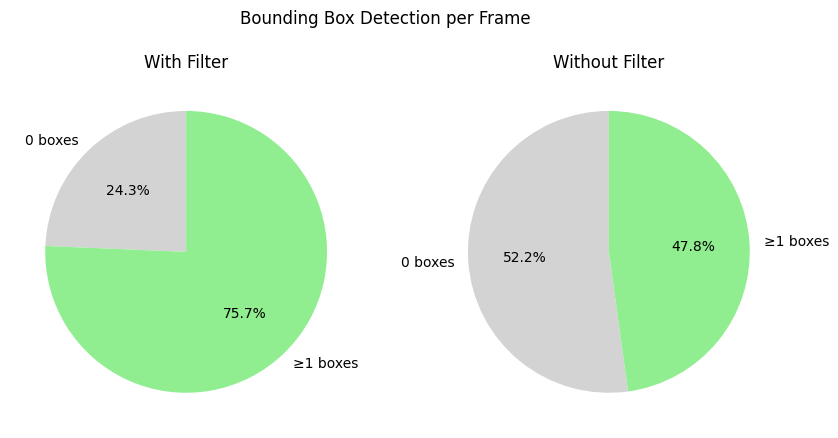

In [12]:
import matplotlib.pyplot as plt

# Counts how many frames have 0 and how many >=1 box
def count_zero_nonzero(lst):
    zeros = sum(1 for x in lst if x == 0)
    nonzeros = len(lst) - zeros
    return [zeros, nonzeros]

counts_with = count_zero_nonzero(valid_boxes_per_frame_with_filter)
counts_without = count_zero_nonzero(valid_boxes_per_frame_without_filter)

labels = ['0 boxes', '≥1 boxes']
colors = ['lightgray', 'lightgreen']

# Graphics
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].pie(counts_with, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
axs[0].set_title('With Filter')

axs[1].pie(counts_without, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
axs[1].set_title('Without Filter')

plt.suptitle("Bounding Box Detection per Frame")
plt.show()

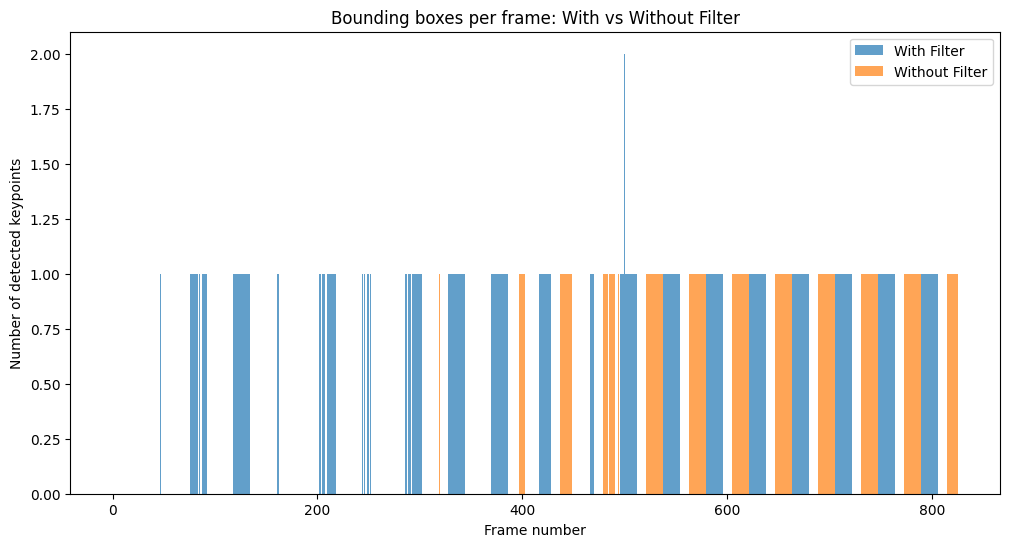

In [13]:
import matplotlib.pyplot as plt

length = min(len(valid_boxes_per_frame_with_filter), len(valid_boxes_per_frame_without_filter))

data_with = valid_boxes_per_frame_with_filter[:length]
data_without = valid_boxes_per_frame_without_filter[:length]


x = np.arange(length)
width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, data_with, width, label='With Filter', alpha=0.7)
plt.bar(x + width/2, data_without, width, label='Without Filter', alpha=0.7)
plt.xlabel('Frame number')
plt.ylabel('Number of detected keypoints')
plt.title('Bounding boxes per frame: With vs Without Filter')
plt.legend()
plt.show()

Total with filter: 628
Total without filter: 395


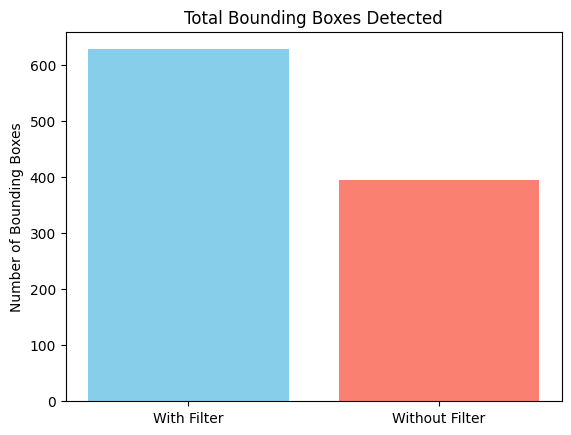

In [14]:
total_with_filter = sum(valid_boxes_per_frame_with_filter)
total_without_filter = sum(valid_boxes_per_frame_without_filter)

print(f"Total with filter: {total_with_filter}")
print(f"Total without filter: {total_without_filter}")

labels = ['With Filter', 'Without Filter']
totals = [total_with_filter, total_without_filter]

# Grafico a barre
plt.bar(labels, totals, color=['skyblue', 'salmon'])
plt.title("Total Bounding Boxes Detected")
plt.ylabel("Number of Bounding Boxes")
plt.show()